Using keras to apply gradient ascent and try to understand what each layer of the ml algorithm is detecting
https://keras.io/examples/vision/visualizing_what_convnets_learn/

In [1]:
import os
import gc
import sys
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Flatten
%matplotlib inline

2022-07-01 14:51:27.114153: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-01 14:51:27.149381: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-01 14:51:27.149393: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
model = load_model("ml_models/cnn_20220627.h5")
fbins = np.array([4000*1.0445**i for i in range(96)])

2022-07-01 14:51:31.676777: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-01 14:51:31.676792: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-01 14:51:31.676819: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ayu): /proc/driver/nvidia/version does not exist
2022-07-01 14:51:31.677153: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 94, 8)             32        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 47, 8)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 45, 8)             200       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 11, 8)            0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 88)                0         
                                                                 
 dense (Dense)               (None, 8)                 7

In [70]:
layer = model.get_layer(name="conv1d_1")
feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)

In [74]:
weights = np.array(layer.get_weights())
print(weights)

[array([[[ 7.99056217e-02, -3.22887689e-01,  8.47347081e-03,
          -2.93341875e-01, -1.55592844e-01, -3.52597743e-01,
          -3.98588479e-02,  3.46110493e-01],
         [ 9.40929532e-01,  1.77818388e-01, -4.79262352e-01,
           4.11885343e-02, -6.88454330e-01,  4.98849839e-01,
          -3.97534855e-02,  1.58960938e-01],
         [-1.37604475e+00,  3.04899514e-02,  1.81797698e-01,
           5.29322505e-01, -8.02388132e-01, -5.06587446e-01,
          -1.51023224e-01, -2.10732251e-01],
         [ 3.73146534e-02,  2.25803778e-01, -3.01669687e-01,
           6.53267264e-01,  1.88177094e-01,  4.64651920e-02,
           2.33142927e-01, -1.59368157e-01],
         [ 2.21673965e-01, -8.58237147e-02,  9.06501263e-02,
          -7.75321007e-01,  1.27911985e-01,  3.01283479e-01,
          -8.41403306e-02,  1.12354115e-01],
         [ 2.91046172e-01, -1.20655209e-01, -3.42079669e-01,
           3.50136310e-01,  2.44308442e-01, -7.01005757e-02,
           2.95000702e-01, -2.72463948e-01]

/tmp/ipykernel_1943/4088476721.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  weights = np.array(layer.get_weights())


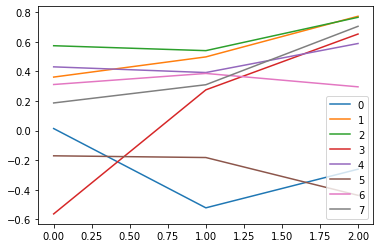

In [66]:
for i in range(8):
    plt.plot(weights[:,:,i], label=i)
plt.legend()

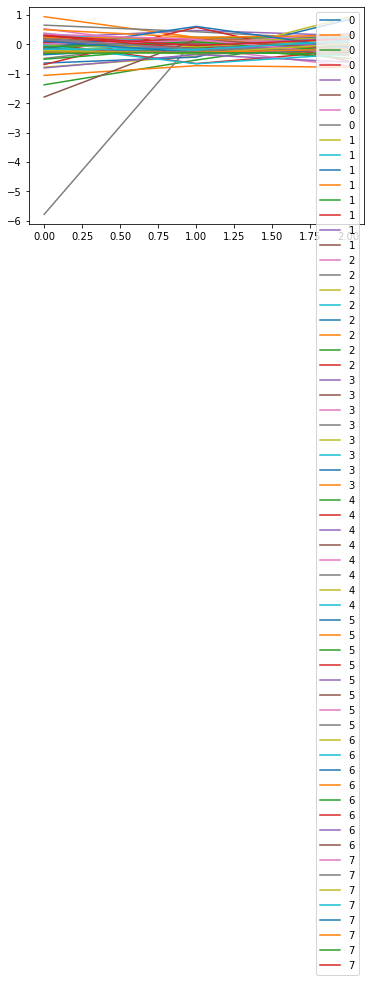

In [72]:
for i in range(8):
    plt.plot(weights[:,:,i], label=i)
plt.legend()

In [40]:
def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[2:-2, filter_index]
    return tf.reduce_mean(filter_activation)


In [41]:
@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img


In [42]:
def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.uniform(shape=(1,96))
    # ResNet50V2 expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.125, +0.125]
    return (img - 0.5) * 0.25


def visualize_filter(filter_index):
    # We run gradient ascent for 20 steps
    iterations = 5000
    learning_rate = .1
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    # Decode the resulting input image
    #img = deprocess_image(img[0].numpy())
    return loss, img


In [43]:
def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    #img = img[25:-25]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

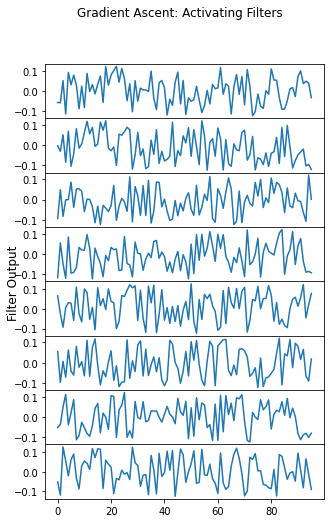

In [67]:
fig, ax = plt.subplots(8, figsize=(5, 8))
plt.subplots_adjust(hspace=0)
fig.suptitle("Gradient Ascent: Activating Filters")
fig.supxlabel("")
fig.supylabel("Filter Output")
for i in range(8):
    loss, img = visualize_filter(i)
    ax[i].plot(img[0])
    #ax[i].set_yscale('log')
    #ax[i].set_ylim((50, 250))
    #ax[i].text(1,100,f"Filter: {i}")

In [11]:
for i in range(8):
    loss, img = visualize_filter(i)
    print(img)

tf.Tensor(
[[-0.05946973 -0.06486821 -0.05862892  0.05274236  0.02442533 -0.01610965
  -0.0473583   0.04959866  0.0250752   0.04308575  0.08917591 -0.02803817
  -0.02841932  0.00993827  0.09286854 -0.05720204 -0.11094043  0.10371566
   0.05407602 -0.11604601  0.0642525   0.03165197 -0.07761034  0.03062066
  -0.10286263 -0.09256685 -0.05233666 -0.05562171 -0.05241218 -0.01874426
   0.07260004 -0.02148077  0.00690991 -0.05330297 -0.05992666  0.11546433
   0.06556997 -0.06507745  0.09710506  0.05629659  0.03891146 -0.0498955
  -0.03504959 -0.07300851 -0.03865266 -0.03708473  0.04692009  0.12407684
  -0.10164636  0.08706582  0.01709756  0.02906346 -0.01154426  0.00434107
   0.05380195 -0.12412688  0.06388581 -0.02421644  0.11058941  0.00707343
  -0.02784497  0.04726094  0.03230903 -0.02391058  0.09643084 -0.00809735
   0.00211805  0.04200637  0.1101734   0.11912322  0.10960534 -0.02218363
  -0.03394353  0.11927411  0.09846693 -0.03964797  0.08718413  0.02192187
  -0.11460841  0.11492667  0